In [46]:
import pandas as pd

df = pd.read_csv('../Dataset/FeatureEngineering_T2M_data.csv')
df.tail()

,date,tsoil1,tsoil2,tsoil3,tsoil4,t2m,t2m_max,t2m_min,t10m,t10m_max,...,t2m_volatility_3d_lag3,t2m_anomaly_lag1,t2m_anomaly_lag2,t2m_anomaly_lag3,temp_gradient_surface_lag1,temp_gradient_surface_lag2,temp_gradient_surface_lag3,wind_chill_factor_lag1,wind_chill_factor_lag2,wind_chill_factor_lag3
16364,2025-11-10,27.22,26.89,26.45,26.50,27.96,30.47,26.15,28.21,30.25,...,0.018506,1.599108,0.979108,0.219108,-0.38,-0.18,-0.26,27.609,27.039,26.639
16365,2025-11-11,27.18,26.98,26.62,26.53,27.73,30.78,25.67,27.92,30.65,...,0.019798,1.779108,1.599108,0.979108,-0.21,-0.38,-0.18,27.944,27.609,27.039
16366,2025-11-12,27.33,27.01,26.71,26.56,28.32,31.13,25.87,28.64,31.10,...,0.025492,1.549108,1.779108,1.599108,-0.17,-0.21,-0.38,27.671,27.944,27.609
16367,2025-11-13,26.98,27.10,26.82,26.59,27.32,29.18,25.70,27.44,29.09,...,0.015188,2.139108,1.549108,1.779108,-0.07,-0.17,-0.21,28.244,27.671,27.944
16368,2025-11-14,25.64,26.43,26.78,26.63,25.75,28.15,23.67,25.84,28.22,...,0.004348,1.139108,2.139108,1.549108,-0.17,-0.07,-0.17,27.398,28.244,27.671


In [47]:
len(df.columns)

399

### X, y and Train / Test for Time Series

In [48]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

In [49]:
H = 7
t2m_targets = [f"t2m_d{h}_forecast" for h in range(1, H+1)]

In [50]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

feature_cols = [c for c in num_cols if c not in t2m_targets]

print("Number of features:", len(feature_cols))
print("Targets:", t2m_targets)

Number of features: 391
Targets: ['t2m_d1_forecast', 't2m_d2_forecast', 't2m_d3_forecast', 't2m_d4_forecast', 't2m_d5_forecast', 't2m_d6_forecast', 't2m_d7_forecast']


In [51]:
X = df[feature_cols]         # shape = (n_samples, n_features)
Y = df[t2m_targets]           # shape = (n_samples, 7)

In [52]:
test_ratio = 0.1
n_samples = len(df)
split_idx = int(n_samples * (1 - test_ratio))

# split
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
Y_train, Y_test = Y.iloc[:split_idx], Y.iloc[split_idx:]

print("Train size:", X_train.shape, Y_train.shape)
print("Test  size:", X_test.shape, Y_test.shape)

Train size: (14732, 391) (14732, 7)
Test  size: (1637, 391) (1637, 7)


### Train LightGBM (Multi-Output)

In [53]:
%pip install lightgbm optuna tqdm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


### feature importance

In [54]:
from lightgbm import LGBMRegressor

t2m_last_col = Y_train.columns[-1]

fs_model = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=63,
    random_state=42,
    n_jobs=-1
)

fs_model.fit(X_train, Y_train[t2m_last_col])

# ดึง feature importance
importances = pd.Series(fs_model.feature_importances_, index=X_train.columns)
importances = importances.sort_values(ascending=False)

# เลือก top-k features
TOP_K = 200  
selected_features = importances.head(TOP_K).index.tolist()

print(f"Selected top {TOP_K} features from LightGBM importance:")
print(selected_features)

X_train_fs = X_train[selected_features].copy()
X_test_fs  = X_test[selected_features].copy()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87228
[LightGBM] [Info] Number of data points in the train set: 14732, number of used features: 391
[LightGBM] [Info] Start training from score 27.870432
Selected top 200 features from LightGBM importance:
['month_progress', 'gwettop_roll7_std', 'dayofyear', 'doy_sin', 'tsoil4_roll7_std', 't2m_trend_strength', 'tsoil3_roll7_std', 'ts_max_roll7_std', 'rhoa_roll3_std', 'to3_lag7', 'to3', 'tsoil4_lag7', 'ts_min_roll7_std', 'gwettop_roll3_std', 'doy_cos', 't2mwet_roll7_std', 'v2m_roll7_std', 'tsoil4_roll3_std', 'rhoa_roll7_std', 'gwetprof_roll7_std', 'to3_lag3', 't2m_max_roll7_std', 'tsoil4', 't10m_min_roll7_std', 't10m_max_roll7_std', 't2m_min_roll7_std', 'tsoil3_lag7', 'to3_lag1', 'v50m_roll7_std', 'gwetroot_roll7_std', 'to3_lag6', 'gwetprof_roll3_std', 'to3_lag2', 'ts_min_roll3_std', 'to3_lag4', 'te

In [55]:
import optuna
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_score
from tqdm.auto import tqdm

# Create validation split for optuna
val_ratio = 0.2
val_split_idx = int(len(X_train_fs) * (1 - val_ratio))

X_train_opt = X_train_fs.iloc[:val_split_idx]
Y_train_opt = Y_train.iloc[:val_split_idx]
X_val_opt   = X_train_fs.iloc[val_split_idx:]
Y_val_opt   = Y_train.iloc[val_split_idx:]

print("Optuna train size:", X_train_opt.shape, Y_train_opt.shape)
print("Optuna val   size:", X_val_opt.shape,   Y_val_opt.shape)

def objective(trial):
    # Suggest hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'objective': 'reg:squarederror',
        'random_state': 42,
        'n_jobs': -1
    }
    
    # Create model
    base_xgb = XGBRegressor(**params)
    model = MultiOutputRegressor(base_xgb)
    
    # Train on training data
    model.fit(X_train_opt, Y_train_opt)
    
    # Predict on validation data
    Y_pred_val = model.predict(X_val_opt)
    
    # Calculate RMSE (objective to minimize)
    rmse = sqrt(mean_squared_error(Y_val_opt, Y_pred_val))
    
    return rmse

# Run Optuna optimization with built-in progress bar
study = optuna.create_study(direction='minimize', 
                           study_name='xgb_t2m_forecast',
                           sampler=optuna.samplers.TPESampler(seed=42))

study.optimize(objective, 
               n_trials=100,
               timeout=5400,  # timeout
               show_progress_bar=True)

# Print best results
print(f"Best RMSE: {study.best_value:.4f}")
print(f"Best parameters:")
for key, value in study.best_params.items():
    print(f"   {key}: {value}")

# Train final model with best parameters
best_params = study.best_params
best_params.update({
    'objective': 'reg:squarederror',
    'random_state': 42,
    'n_jobs': -1
})

[I 2025-11-25 04:28:49,979] A new study created in memory with name: xgb_t2m_forecast


Optuna train size: (11785, 200) (11785, 7)
Optuna val   size: (2947, 200) (2947, 7)


Best trial: 0. Best value: 1.20095:   1%|          | 1/100 [01:50<3:02:12, 110.43s/it, 110.43/5400 seconds]

[I 2025-11-25 04:30:40,412] Trial 0 finished with value: 1.2009500934576811 and parameters: {'n_estimators': 437, 'learning_rate': 0.2536999076681772, 'max_depth': 12, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'reg_alpha': 2.5348407664333426e-07, 'reg_lambda': 3.3323645788192616e-08, 'min_child_weight': 9}. Best is trial 0 with value: 1.2009500934576811.


Best trial: 1. Best value: 1.13217:   2%|▏         | 2/100 [02:17<1:40:07, 61.30s/it, 137.33/5400 seconds] 

[I 2025-11-25 04:31:07,310] Trial 1 finished with value: 1.1321681327542654 and parameters: {'n_estimators': 641, 'learning_rate': 0.11114989443094977, 'max_depth': 3, 'subsample': 0.9879639408647978, 'colsample_bytree': 0.9329770563201687, 'reg_alpha': 8.148018307012941e-07, 'reg_lambda': 4.329370014459266e-07, 'min_child_weight': 2}. Best is trial 1 with value: 1.1321681327542654.


Best trial: 1. Best value: 1.13217:   3%|▎         | 3/100 [03:46<1:59:45, 74.08s/it, 226.63/5400 seconds]

[I 2025-11-25 04:32:36,607] Trial 2 finished with value: 1.1323749618050218 and parameters: {'n_estimators': 374, 'learning_rate': 0.05958389350068958, 'max_depth': 8, 'subsample': 0.7164916560792167, 'colsample_bytree': 0.8447411578889518, 'reg_alpha': 1.8007140198129195e-07, 'reg_lambda': 4.258943089524393e-06, 'min_child_weight': 4}. Best is trial 1 with value: 1.1321681327542654.


Best trial: 1. Best value: 1.13217:   4%|▍         | 4/100 [04:22<1:34:13, 58.89s/it, 262.24/5400 seconds]

[I 2025-11-25 04:33:12,218] Trial 3 finished with value: 1.1647838943013804 and parameters: {'n_estimators': 510, 'learning_rate': 0.14447746112718687, 'max_depth': 5, 'subsample': 0.8056937753654446, 'colsample_bytree': 0.836965827544817, 'reg_alpha': 2.6185068507773707e-08, 'reg_lambda': 0.0029369981104377003, 'min_child_weight': 2}. Best is trial 1 with value: 1.1321681327542654.


Best trial: 1. Best value: 1.13217:   5%|▌         | 5/100 [06:17<2:05:39, 79.37s/it, 377.91/5400 seconds]

[I 2025-11-25 04:35:07,888] Trial 4 finished with value: 1.1870566092460324 and parameters: {'n_estimators': 158, 'learning_rate': 0.2521267904777921, 'max_depth': 15, 'subsample': 0.9233589392465844, 'colsample_bytree': 0.7218455076693483, 'reg_alpha': 7.569183361880229e-08, 'reg_lambda': 0.014391207615728067, 'min_child_weight': 5}. Best is trial 1 with value: 1.1321681327542654.


Best trial: 5. Best value: 1.10093:   6%|▌         | 6/100 [06:28<1:27:30, 55.86s/it, 388.14/5400 seconds]

[I 2025-11-25 04:35:18,119] Trial 5 finished with value: 1.100925721433869 and parameters: {'n_estimators': 209, 'learning_rate': 0.05388108577817234, 'max_depth': 3, 'subsample': 0.9637281608315128, 'colsample_bytree': 0.7035119926400067, 'reg_alpha': 0.009176996354542699, 'reg_lambda': 6.388511557344611e-06, 'min_child_weight': 6}. Best is trial 5 with value: 1.100925721433869.


Best trial: 5. Best value: 1.10093:   7%|▋         | 7/100 [15:28<5:31:52, 214.12s/it, 928.07/5400 seconds]

[I 2025-11-25 04:44:18,053] Trial 6 finished with value: 1.1290325899277476 and parameters: {'n_estimators': 592, 'learning_rate': 0.01875220945578641, 'max_depth': 15, 'subsample': 0.9100531293444458, 'colsample_bytree': 0.9757995766256756, 'reg_alpha': 1.1309571585271483, 'reg_lambda': 0.002404915432737351, 'min_child_weight': 10}. Best is trial 5 with value: 1.100925721433869.


Best trial: 5. Best value: 1.10093:   8%|▊         | 8/100 [15:35<3:47:15, 148.21s/it, 935.17/5400 seconds]

[I 2025-11-25 04:44:25,147] Trial 7 finished with value: 1.1050893718946775 and parameters: {'n_estimators': 179, 'learning_rate': 0.01947558230629543, 'max_depth': 3, 'subsample': 0.7301321323053057, 'colsample_bytree': 0.7554709158757928, 'reg_alpha': 2.7678419414850017e-06, 'reg_lambda': 0.28749982347407854, 'min_child_weight': 4}. Best is trial 5 with value: 1.100925721433869.


Best trial: 5. Best value: 1.10093:   9%|▉         | 9/100 [15:50<2:41:37, 106.56s/it, 950.15/5400 seconds]

[I 2025-11-25 04:44:40,132] Trial 8 finished with value: 1.114411486393677 and parameters: {'n_estimators': 353, 'learning_rate': 0.06333268775321843, 'max_depth': 4, 'subsample': 0.9208787923016158, 'colsample_bytree': 0.6298202574719083, 'reg_alpha': 7.620481786158549, 'reg_lambda': 0.08916674715636537, 'min_child_weight': 2}. Best is trial 5 with value: 1.100925721433869.


Best trial: 5. Best value: 1.10093:  10%|█         | 10/100 [17:37<2:40:20, 106.89s/it, 1057.78/5400 seconds]

[I 2025-11-25 04:46:27,757] Trial 9 finished with value: 1.1638301643107374 and parameters: {'n_estimators': 104, 'learning_rate': 0.1601531217136121, 'max_depth': 12, 'subsample': 0.8916028672163949, 'colsample_bytree': 0.9085081386743783, 'reg_alpha': 4.638759594322625e-08, 'reg_lambda': 1.683416412018213e-05, 'min_child_weight': 2}. Best is trial 5 with value: 1.100925721433869.


Best trial: 5. Best value: 1.10093:  11%|█         | 11/100 [19:23<2:38:00, 106.52s/it, 1163.47/5400 seconds]

[I 2025-11-25 04:48:13,448] Trial 10 finished with value: 1.111614223989496 and parameters: {'n_estimators': 951, 'learning_rate': 0.010206070557577008, 'max_depth': 7, 'subsample': 0.6071847502459279, 'colsample_bytree': 0.7090747508804338, 'reg_alpha': 0.016301353379407586, 'reg_lambda': 4.3444691085504035, 'min_child_weight': 7}. Best is trial 5 with value: 1.100925721433869.


Best trial: 5. Best value: 1.10093:  12%|█▏        | 12/100 [19:46<1:58:45, 80.98s/it, 1186.01/5400 seconds] 

[I 2025-11-25 04:48:35,990] Trial 11 finished with value: 1.1096495167820353 and parameters: {'n_estimators': 262, 'learning_rate': 0.028310060673998678, 'max_depth': 6, 'subsample': 0.7184348852751731, 'colsample_bytree': 0.7628905526894346, 'reg_alpha': 7.001736496003668e-05, 'reg_lambda': 7.476931580627821e-05, 'min_child_weight': 7}. Best is trial 5 with value: 1.100925721433869.


Best trial: 12. Best value: 1.09865:  13%|█▎        | 13/100 [19:54<1:25:42, 59.11s/it, 1194.82/5400 seconds]

[I 2025-11-25 04:48:44,802] Trial 12 finished with value: 1.0986462672787218 and parameters: {'n_estimators': 244, 'learning_rate': 0.030844277238946734, 'max_depth': 3, 'subsample': 0.6857486542395244, 'colsample_bytree': 0.7835458343977252, 'reg_alpha': 0.00014777784917522382, 'reg_lambda': 8.876711193233222, 'min_child_weight': 4}. Best is trial 12 with value: 1.0986462672787218.


Best trial: 12. Best value: 1.09865:  14%|█▍        | 14/100 [22:51<2:15:37, 94.62s/it, 1371.49/5400 seconds]

[I 2025-11-25 04:51:41,465] Trial 13 finished with value: 1.1270267984780176 and parameters: {'n_estimators': 731, 'learning_rate': 0.03328530193656596, 'max_depth': 9, 'subsample': 0.6087190477387632, 'colsample_bytree': 0.8056891692692755, 'reg_alpha': 0.00577000336562851, 'reg_lambda': 9.868745464853728, 'min_child_weight': 7}. Best is trial 12 with value: 1.0986462672787218.


Best trial: 12. Best value: 1.09865:  15%|█▌        | 15/100 [23:07<1:40:25, 70.89s/it, 1387.39/5400 seconds]

[I 2025-11-25 04:51:57,373] Trial 14 finished with value: 1.1060730054397072 and parameters: {'n_estimators': 269, 'learning_rate': 0.036369411327369344, 'max_depth': 5, 'subsample': 0.6638123593227387, 'colsample_bytree': 0.6052561262871233, 'reg_alpha': 0.00025481147055211206, 'reg_lambda': 1.0101672095939463e-06, 'min_child_weight': 5}. Best is trial 12 with value: 1.0986462672787218.


Best trial: 12. Best value: 1.09865:  16%|█▌        | 16/100 [24:41<1:49:14, 78.03s/it, 1481.99/5400 seconds]

[I 2025-11-25 04:53:31,966] Trial 15 finished with value: 1.1381848505865004 and parameters: {'n_estimators': 273, 'learning_rate': 0.09160994419974844, 'max_depth': 10, 'subsample': 0.9914618266037012, 'colsample_bytree': 0.6874613708719653, 'reg_alpha': 0.010808425643174122, 'reg_lambda': 0.00010014623957310808, 'min_child_weight': 4}. Best is trial 12 with value: 1.0986462672787218.


Best trial: 12. Best value: 1.09865:  17%|█▋        | 17/100 [24:57<1:22:02, 59.31s/it, 1497.77/5400 seconds]

[I 2025-11-25 04:53:47,753] Trial 16 finished with value: 1.105473063430189 and parameters: {'n_estimators': 477, 'learning_rate': 0.0459790367430304, 'max_depth': 3, 'subsample': 0.7751041189931617, 'colsample_bytree': 0.7585197880317976, 'reg_alpha': 1.696539252317122e-05, 'reg_lambda': 1.1032173338053777e-08, 'min_child_weight': 6}. Best is trial 12 with value: 1.0986462672787218.


Best trial: 12. Best value: 1.09865:  18%|█▊        | 18/100 [26:02<1:23:05, 60.79s/it, 1562.02/5400 seconds]

[I 2025-11-25 04:54:51,998] Trial 17 finished with value: 1.1115227446740779 and parameters: {'n_estimators': 795, 'learning_rate': 0.017029949879386743, 'max_depth': 6, 'subsample': 0.6681683669330878, 'colsample_bytree': 0.8714982728343171, 'reg_alpha': 0.14816027017474237, 'reg_lambda': 0.0006765519759549801, 'min_child_weight': 8}. Best is trial 12 with value: 1.0986462672787218.


Best trial: 12. Best value: 1.09865:  19%|█▉        | 19/100 [26:23<1:06:05, 48.96s/it, 1583.40/5400 seconds]

[I 2025-11-25 04:55:13,381] Trial 18 finished with value: 1.1293210650148844 and parameters: {'n_estimators': 339, 'learning_rate': 0.08389012487233569, 'max_depth': 5, 'subsample': 0.8532073337025083, 'colsample_bytree': 0.7999631989857672, 'reg_alpha': 0.0012711670269203337, 'reg_lambda': 0.4226650862341932, 'min_child_weight': 1}. Best is trial 12 with value: 1.0986462672787218.


Best trial: 12. Best value: 1.09865:  20%|██        | 20/100 [28:02<1:25:12, 63.91s/it, 1682.17/5400 seconds]

[I 2025-11-25 04:56:52,148] Trial 19 finished with value: 1.1173927812109945 and parameters: {'n_estimators': 184, 'learning_rate': 0.024550704048609658, 'max_depth': 11, 'subsample': 0.7730982444721965, 'colsample_bytree': 0.6531827218643451, 'reg_alpha': 0.09245644371904305, 'reg_lambda': 2.0264826025670548e-07, 'min_child_weight': 6}. Best is trial 12 with value: 1.0986462672787218.


Best trial: 12. Best value: 1.09865:  21%|██        | 21/100 [28:58<1:21:07, 61.62s/it, 1738.44/5400 seconds]

[I 2025-11-25 04:57:48,424] Trial 20 finished with value: 1.1080825691684306 and parameters: {'n_estimators': 399, 'learning_rate': 0.011159973194409685, 'max_depth': 7, 'subsample': 0.6628974418511198, 'colsample_bytree': 0.7298877464178883, 'reg_alpha': 2.200242419836091e-05, 'reg_lambda': 7.809808776078162e-06, 'min_child_weight': 3}. Best is trial 12 with value: 1.0986462672787218.


Best trial: 12. Best value: 1.09865:  22%|██▏       | 22/100 [29:06<59:14, 45.57s/it, 1746.59/5400 seconds]  

[I 2025-11-25 04:57:56,571] Trial 21 finished with value: 1.102006646837242 and parameters: {'n_estimators': 205, 'learning_rate': 0.01956420274015602, 'max_depth': 3, 'subsample': 0.7097437403873375, 'colsample_bytree': 0.7674884625737328, 'reg_alpha': 3.3295934684740635e-06, 'reg_lambda': 0.7941994767896431, 'min_child_weight': 4}. Best is trial 12 with value: 1.0986462672787218.


Best trial: 12. Best value: 1.09865:  23%|██▎       | 23/100 [29:17<45:05, 35.13s/it, 1757.38/5400 seconds]

[I 2025-11-25 04:58:07,360] Trial 22 finished with value: 1.1036168414933503 and parameters: {'n_estimators': 232, 'learning_rate': 0.04308515119132366, 'max_depth': 4, 'subsample': 0.6965645209738722, 'colsample_bytree': 0.775612818156987, 'reg_alpha': 0.0006834446679140867, 'reg_lambda': 2.433360618525544, 'min_child_weight': 5}. Best is trial 12 with value: 1.0986462672787218.


Best trial: 12. Best value: 1.09865:  24%|██▍       | 24/100 [29:24<33:49, 26.71s/it, 1764.43/5400 seconds]

[I 2025-11-25 04:58:14,407] Trial 23 finished with value: 1.158028549237716 and parameters: {'n_estimators': 123, 'learning_rate': 0.013873161725030819, 'max_depth': 4, 'subsample': 0.7467650166805597, 'colsample_bytree': 0.8038444117507164, 'reg_alpha': 2.2906849913723496e-06, 'reg_lambda': 0.7352125975122539, 'min_child_weight': 3}. Best is trial 12 with value: 1.0986462672787218.


Best trial: 24. Best value: 1.09609:  25%|██▌       | 25/100 [29:34<27:10, 21.74s/it, 1774.58/5400 seconds]

[I 2025-11-25 04:58:24,560] Trial 24 finished with value: 1.0960885252389618 and parameters: {'n_estimators': 279, 'learning_rate': 0.023358447944319235, 'max_depth': 3, 'subsample': 0.6375332146169699, 'colsample_bytree': 0.6746648725658929, 'reg_alpha': 0.0021712907417280243, 'reg_lambda': 0.04632572473141108, 'min_child_weight': 4}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  26%|██▌       | 26/100 [29:59<28:05, 22.78s/it, 1799.79/5400 seconds]

[I 2025-11-25 04:58:49,772] Trial 25 finished with value: 1.1105540819769502 and parameters: {'n_estimators': 303, 'learning_rate': 0.02781303883374896, 'max_depth': 6, 'subsample': 0.6339462897949991, 'colsample_bytree': 0.7012541167769073, 'reg_alpha': 0.0016619171178759017, 'reg_lambda': 0.020473626035747247, 'min_child_weight': 6}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  27%|██▋       | 27/100 [30:17<25:57, 21.33s/it, 1817.73/5400 seconds]

[I 2025-11-25 04:59:07,711] Trial 26 finished with value: 1.1105891823131688 and parameters: {'n_estimators': 426, 'learning_rate': 0.042900474037941845, 'max_depth': 4, 'subsample': 0.6347264216551218, 'colsample_bytree': 0.6687840829785424, 'reg_alpha': 0.0001611821706994179, 'reg_lambda': 0.02607882645530152, 'min_child_weight': 3}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  28%|██▊       | 28/100 [30:34<23:53, 19.92s/it, 1834.35/5400 seconds]

[I 2025-11-25 04:59:24,333] Trial 27 finished with value: 1.1231798176238703 and parameters: {'n_estimators': 315, 'learning_rate': 0.068537406457222, 'max_depth': 5, 'subsample': 0.9567827716334928, 'colsample_bytree': 0.6037140669308542, 'reg_alpha': 0.07850821031886417, 'reg_lambda': 0.0002791364363389297, 'min_child_weight': 8}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  29%|██▉       | 29/100 [30:53<23:15, 19.66s/it, 1853.42/5400 seconds]

[I 2025-11-25 04:59:43,396] Trial 28 finished with value: 1.099291631889297 and parameters: {'n_estimators': 571, 'learning_rate': 0.024453917784846707, 'max_depth': 3, 'subsample': 0.8206941098461726, 'colsample_bytree': 0.7371353101672381, 'reg_alpha': 0.0036018301732339466, 'reg_lambda': 0.06190164769079017, 'min_child_weight': 5}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  30%|███       | 30/100 [32:01<39:51, 34.17s/it, 1921.42/5400 seconds]

[I 2025-11-25 05:00:51,404] Trial 29 finished with value: 1.111467456631218 and parameters: {'n_estimators': 579, 'learning_rate': 0.014042850055929675, 'max_depth': 7, 'subsample': 0.85015594650789, 'colsample_bytree': 0.6565755636205177, 'reg_alpha': 3.916888866842479e-05, 'reg_lambda': 0.07125411166708784, 'min_child_weight': 5}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  31%|███       | 31/100 [39:08<2:54:58, 152.16s/it, 2348.89/5400 seconds]

[I 2025-11-25 05:07:58,874] Trial 30 finished with value: 1.1233000627471328 and parameters: {'n_estimators': 486, 'learning_rate': 0.02361414202948074, 'max_depth': 13, 'subsample': 0.8047873411189876, 'colsample_bytree': 0.6778411975988842, 'reg_alpha': 0.0024623862073336993, 'reg_lambda': 0.0048333842511709335, 'min_child_weight': 3}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  32%|███▏      | 32/100 [39:30<2:08:03, 113.00s/it, 2370.52/5400 seconds]

[I 2025-11-25 05:08:20,505] Trial 31 finished with value: 1.105645964204327 and parameters: {'n_estimators': 671, 'learning_rate': 0.03696096647012694, 'max_depth': 3, 'subsample': 0.8272370604086507, 'colsample_bytree': 0.7347018719055417, 'reg_alpha': 0.03130248693600455, 'reg_lambda': 0.17580709452768514, 'min_child_weight': 6}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  33%|███▎      | 33/100 [39:48<1:34:22, 84.52s/it, 2388.60/5400 seconds] 

[I 2025-11-25 05:08:38,580] Trial 32 finished with value: 1.110335189712043 and parameters: {'n_estimators': 429, 'learning_rate': 0.049615719169383725, 'max_depth': 4, 'subsample': 0.8791869593999033, 'colsample_bytree': 0.6310124238594453, 'reg_alpha': 0.5336266936847235, 'reg_lambda': 1.9201042644370496, 'min_child_weight': 4}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  34%|███▍      | 34/100 [40:17<1:14:38, 67.86s/it, 2417.58/5400 seconds]

[I 2025-11-25 05:09:07,564] Trial 33 finished with value: 1.1052020394843851 and parameters: {'n_estimators': 869, 'learning_rate': 0.029144427000895423, 'max_depth': 3, 'subsample': 0.6839213878606012, 'colsample_bytree': 0.694494095260054, 'reg_alpha': 0.005138623777232002, 'reg_lambda': 0.0007616776168097339, 'min_child_weight': 5}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  35%|███▌      | 35/100 [40:35<57:12, 52.81s/it, 2435.28/5400 seconds]  

[I 2025-11-25 05:09:25,263] Trial 34 finished with value: 1.1005567463859762 and parameters: {'n_estimators': 533, 'learning_rate': 0.022253911651690248, 'max_depth': 3, 'subsample': 0.9478926911227507, 'colsample_bytree': 0.7421987459939546, 'reg_alpha': 0.00044051724349868446, 'reg_lambda': 1.261359391194559e-07, 'min_child_weight': 4}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  36%|███▌      | 36/100 [41:13<51:45, 48.53s/it, 2473.81/5400 seconds]

[I 2025-11-25 05:10:03,791] Trial 35 finished with value: 1.1127313159101642 and parameters: {'n_estimators': 647, 'learning_rate': 0.022948088103715146, 'max_depth': 5, 'subsample': 0.7587631745884615, 'colsample_bytree': 0.8265398477432064, 'reg_alpha': 0.00039283267232557496, 'reg_lambda': 1.0843703833908492e-07, 'min_child_weight': 3}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  37%|███▋      | 37/100 [41:43<45:07, 42.98s/it, 2503.85/5400 seconds]

[I 2025-11-25 05:10:33,827] Trial 36 finished with value: 1.1021592708354697 and parameters: {'n_estimators': 700, 'learning_rate': 0.01697448911598911, 'max_depth': 4, 'subsample': 0.6307756565861931, 'colsample_bytree': 0.7349100832549772, 'reg_alpha': 0.00012007755266826941, 'reg_lambda': 1.5546441261238122e-06, 'min_child_weight': 4}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  38%|███▊      | 38/100 [42:03<37:07, 35.93s/it, 2523.32/5400 seconds]

[I 2025-11-25 05:10:53,296] Trial 37 finished with value: 1.1037379758186365 and parameters: {'n_estimators': 552, 'learning_rate': 0.0313828478412046, 'max_depth': 3, 'subsample': 0.9499139101958196, 'colsample_bytree': 0.8773394984414487, 'reg_alpha': 1.4605923189514736e-05, 'reg_lambda': 0.00958810606115971, 'min_child_weight': 1}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  39%|███▉      | 39/100 [43:43<56:14, 55.33s/it, 2623.91/5400 seconds]

[I 2025-11-25 05:12:33,890] Trial 38 finished with value: 1.1143103945709711 and parameters: {'n_estimators': 518, 'learning_rate': 0.013923276374124022, 'max_depth': 8, 'subsample': 0.873289490257277, 'colsample_bytree': 0.7838411618943656, 'reg_alpha': 1.0568458624858643e-08, 'reg_lambda': 0.055041182252280545, 'min_child_weight': 4}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  40%|████      | 40/100 [44:48<57:58, 57.97s/it, 2688.04/5400 seconds]

[I 2025-11-25 05:13:38,022] Trial 39 finished with value: 1.117026310743179 and parameters: {'n_estimators': 760, 'learning_rate': 0.022139812061333777, 'max_depth': 6, 'subsample': 0.8188706259299265, 'colsample_bytree': 0.828815304333899, 'reg_alpha': 0.0008882138367750771, 'reg_lambda': 9.14793237077749, 'min_child_weight': 5}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  41%|████      | 41/100 [58:34<4:43:46, 288.58s/it, 3514.72/5400 seconds]

[I 2025-11-25 05:27:24,696] Trial 40 finished with value: 1.1207381691411409 and parameters: {'n_estimators': 589, 'learning_rate': 0.015916061729469792, 'max_depth': 14, 'subsample': 0.6830967925279993, 'colsample_bytree': 0.7450900550910469, 'reg_alpha': 0.0034686067890197137, 'reg_lambda': 0.0015585720634171381, 'min_child_weight': 2}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  42%|████▏     | 42/100 [58:40<3:17:00, 203.80s/it, 3520.71/5400 seconds]

[I 2025-11-25 05:27:30,690] Trial 41 finished with value: 1.1001476643891939 and parameters: {'n_estimators': 145, 'learning_rate': 0.03843909865351892, 'max_depth': 3, 'subsample': 0.9031259970235475, 'colsample_bytree': 0.7146970966289141, 'reg_alpha': 0.018775363230976973, 'reg_lambda': 6.296039396625125e-08, 'min_child_weight': 6}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  43%|████▎     | 43/100 [58:47<2:17:20, 144.57s/it, 3527.07/5400 seconds]

[I 2025-11-25 05:27:37,049] Trial 42 finished with value: 1.0987657797139248 and parameters: {'n_estimators': 158, 'learning_rate': 0.03934440743049498, 'max_depth': 3, 'subsample': 0.9310069786028577, 'colsample_bytree': 0.7185898700596176, 'reg_alpha': 0.028654616917692936, 'reg_lambda': 5.0908049997659116e-08, 'min_child_weight': 5}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  44%|████▍     | 44/100 [58:54<1:36:27, 103.34s/it, 3534.21/5400 seconds]

[I 2025-11-25 05:27:44,194] Trial 43 finished with value: 1.101580842859664 and parameters: {'n_estimators': 133, 'learning_rate': 0.03814443129002845, 'max_depth': 4, 'subsample': 0.9113643095470947, 'colsample_bytree': 0.7021667419979043, 'reg_alpha': 0.04142666960818288, 'reg_lambda': 2.5303270952672936e-08, 'min_child_weight': 5}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  45%|████▌     | 45/100 [59:05<1:09:21, 75.67s/it, 3545.30/5400 seconds] 

[I 2025-11-25 05:27:55,283] Trial 44 finished with value: 1.1098699942913182 and parameters: {'n_estimators': 163, 'learning_rate': 0.053220216781434106, 'max_depth': 5, 'subsample': 0.9006931330614046, 'colsample_bytree': 0.7108361126766818, 'reg_alpha': 0.3955525769750757, 'reg_lambda': 3.302045275366822e-05, 'min_child_weight': 7}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  46%|████▌     | 46/100 [59:13<49:57, 55.51s/it, 3553.78/5400 seconds]  

[I 2025-11-25 05:28:03,757] Trial 45 finished with value: 1.1023310151638606 and parameters: {'n_estimators': 232, 'learning_rate': 0.06617949693943201, 'max_depth': 3, 'subsample': 0.872866231255747, 'colsample_bytree': 0.6447121666090923, 'reg_alpha': 3.093254368015326, 'reg_lambda': 9.185268511157417e-07, 'min_child_weight': 6}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  47%|████▋     | 47/100 [59:32<39:11, 44.36s/it, 3572.12/5400 seconds]

[I 2025-11-25 05:28:22,099] Trial 46 finished with value: 1.105143091335672 and parameters: {'n_estimators': 384, 'learning_rate': 0.0263248091055068, 'max_depth': 4, 'subsample': 0.972399982549262, 'colsample_bytree': 0.7183073285190392, 'reg_alpha': 0.021630791068890706, 'reg_lambda': 3.560759115307157e-07, 'min_child_weight': 8}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  48%|████▊     | 48/100 [59:38<28:35, 32.99s/it, 3578.59/5400 seconds]

[I 2025-11-25 05:28:28,565] Trial 47 finished with value: 1.102907752671276 and parameters: {'n_estimators': 120, 'learning_rate': 0.03467740035379614, 'max_depth': 3, 'subsample': 0.9287038863200582, 'colsample_bytree': 0.7877963567628524, 'reg_alpha': 0.1957730810353341, 'reg_lambda': 3.785747414929348e-08, 'min_child_weight': 10}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  49%|████▉     | 49/100 [59:50<22:40, 26.68s/it, 3590.54/5400 seconds]

[I 2025-11-25 05:28:40,520] Trial 48 finished with value: 1.1515037966792747 and parameters: {'n_estimators': 161, 'learning_rate': 0.18989508908101135, 'max_depth': 5, 'subsample': 0.9750564502499062, 'colsample_bytree': 0.6833877531963483, 'reg_alpha': 0.009402632154346958, 'reg_lambda': 2.8994728092337683e-06, 'min_child_weight': 5}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  50%|█████     | 50/100 [1:00:02<18:28, 22.17s/it, 3602.19/5400 seconds]

[I 2025-11-25 05:28:52,167] Trial 49 finished with value: 1.1039343655536398 and parameters: {'n_estimators': 227, 'learning_rate': 0.04090447060111135, 'max_depth': 4, 'subsample': 0.9293897343620524, 'colsample_bytree': 0.7554167513317692, 'reg_alpha': 2.9570980022219586e-07, 'reg_lambda': 0.16362486351259092, 'min_child_weight': 7}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  51%|█████     | 51/100 [1:00:12<15:18, 18.74s/it, 3612.91/5400 seconds]

[I 2025-11-25 05:29:02,890] Trial 50 finished with value: 1.0994658842358183 and parameters: {'n_estimators': 274, 'learning_rate': 0.031732218741676324, 'max_depth': 3, 'subsample': 0.7824676267021952, 'colsample_bytree': 0.9752507306199916, 'reg_alpha': 0.03926265453152957, 'reg_lambda': 5.38216678900717e-08, 'min_child_weight': 6}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  52%|█████▏    | 52/100 [1:00:23<13:02, 16.31s/it, 3623.56/5400 seconds]

[I 2025-11-25 05:29:13,543] Trial 51 finished with value: 1.0997498661361165 and parameters: {'n_estimators': 279, 'learning_rate': 0.031635578577463914, 'max_depth': 3, 'subsample': 0.7931257446989887, 'colsample_bytree': 0.9176400665606941, 'reg_alpha': 0.042853183458946134, 'reg_lambda': 3.9155953813397406e-08, 'min_child_weight': 6}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  53%|█████▎    | 53/100 [1:00:34<11:36, 14.82s/it, 3634.89/5400 seconds]

[I 2025-11-25 05:29:24,873] Trial 52 finished with value: 1.0983507124799827 and parameters: {'n_estimators': 298, 'learning_rate': 0.03171212593078502, 'max_depth': 3, 'subsample': 0.7842720614990246, 'colsample_bytree': 0.998219588154087, 'reg_alpha': 0.058877976716850695, 'reg_lambda': 1.1320140549097833e-08, 'min_child_weight': 5}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  54%|█████▍    | 54/100 [1:00:52<11:55, 15.55s/it, 3652.16/5400 seconds]

[I 2025-11-25 05:29:42,143] Trial 53 finished with value: 1.10034063223639 and parameters: {'n_estimators': 329, 'learning_rate': 0.018962010129306105, 'max_depth': 4, 'subsample': 0.7353766201027031, 'colsample_bytree': 0.9908984193515572, 'reg_alpha': 0.9378999745474841, 'reg_lambda': 1.1114567561405094e-08, 'min_child_weight': 5}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  55%|█████▌    | 55/100 [1:01:06<11:22, 15.16s/it, 3666.41/5400 seconds]

[I 2025-11-25 05:29:56,388] Trial 54 finished with value: 1.1002974043127234 and parameters: {'n_estimators': 368, 'learning_rate': 0.030050841543842636, 'max_depth': 3, 'subsample': 0.7652875996218265, 'colsample_bytree': 0.9584360616515396, 'reg_alpha': 0.0078054792990012, 'reg_lambda': 1.6506497374122676e-08, 'min_child_weight': 4}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  56%|█████▌    | 56/100 [1:01:17<10:12, 13.91s/it, 3677.40/5400 seconds]

[I 2025-11-25 05:30:07,383] Trial 55 finished with value: 1.0981061020399077 and parameters: {'n_estimators': 198, 'learning_rate': 0.026220296322248888, 'max_depth': 4, 'subsample': 0.6175424476175838, 'colsample_bytree': 0.9811160054874672, 'reg_alpha': 0.07973452007945529, 'reg_lambda': 2.504246178790385e-07, 'min_child_weight': 5}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  57%|█████▋    | 57/100 [1:01:31<10:04, 14.06s/it, 3691.80/5400 seconds]

[I 2025-11-25 05:30:21,775] Trial 56 finished with value: 1.1022515813306133 and parameters: {'n_estimators': 196, 'learning_rate': 0.025951886861682972, 'max_depth': 5, 'subsample': 0.601267107339948, 'colsample_bytree': 0.9476525103089433, 'reg_alpha': 0.14993869453306932, 'reg_lambda': 3.815437779868702e-07, 'min_child_weight': 5}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  58%|█████▊    | 58/100 [1:03:02<25:55, 37.04s/it, 3782.47/5400 seconds]

[I 2025-11-25 05:31:52,444] Trial 57 finished with value: 1.1147183428604766 and parameters: {'n_estimators': 251, 'learning_rate': 0.02083555606538778, 'max_depth': 9, 'subsample': 0.6495213908275986, 'colsample_bytree': 0.9888830049651377, 'reg_alpha': 0.0023045521444543726, 'reg_lambda': 0.00010100561573049289, 'min_child_weight': 3}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  59%|█████▉    | 59/100 [1:03:17<20:49, 30.46s/it, 3797.59/5400 seconds]

[I 2025-11-25 05:32:07,564] Trial 58 finished with value: 1.1071642486861313 and parameters: {'n_estimators': 297, 'learning_rate': 0.045427691705870216, 'max_depth': 4, 'subsample': 0.6140144859346387, 'colsample_bytree': 0.8788836093126092, 'reg_alpha': 2.3710888643059467, 'reg_lambda': 0.007669073264005684, 'min_child_weight': 4}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  60%|██████    | 60/100 [1:03:47<20:08, 30.22s/it, 3827.23/5400 seconds]

[I 2025-11-25 05:32:37,207] Trial 59 finished with value: 1.1103555348777336 and parameters: {'n_estimators': 469, 'learning_rate': 0.026448888181805807, 'max_depth': 5, 'subsample': 0.6212134107093543, 'colsample_bytree': 0.8556487363985458, 'reg_alpha': 0.24537385029689657, 'reg_lambda': 0.9343620905263528, 'min_child_weight': 5}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  61%|██████    | 61/100 [1:05:10<29:57, 46.09s/it, 3910.34/5400 seconds]

[I 2025-11-25 05:34:00,319] Trial 60 finished with value: 1.1378723268776092 and parameters: {'n_estimators': 205, 'learning_rate': 0.07965061768796042, 'max_depth': 10, 'subsample': 0.6494359369714903, 'colsample_bytree': 0.960934548601413, 'reg_alpha': 0.0010642682608412095, 'reg_lambda': 1.4049166372532002e-05, 'min_child_weight': 4}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  62%|██████▏   | 62/100 [1:05:20<22:24, 35.38s/it, 3920.73/5400 seconds]

[I 2025-11-25 05:34:10,711] Trial 61 finished with value: 1.0992204916912451 and parameters: {'n_estimators': 259, 'learning_rate': 0.03114642771272054, 'max_depth': 3, 'subsample': 0.7931464302798663, 'colsample_bytree': 0.9692371630159239, 'reg_alpha': 0.06725805245843064, 'reg_lambda': 6.907223364627254e-08, 'min_child_weight': 6}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  63%|██████▎   | 63/100 [1:05:32<17:29, 28.37s/it, 3932.75/5400 seconds]

[I 2025-11-25 05:34:22,727] Trial 62 finished with value: 1.1015260839192063 and parameters: {'n_estimators': 246, 'learning_rate': 0.025156110640170433, 'max_depth': 4, 'subsample': 0.8324603232987744, 'colsample_bytree': 0.930788738985598, 'reg_alpha': 0.08729089722962696, 'reg_lambda': 1.7052004907509719e-07, 'min_child_weight': 5}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  64%|██████▍   | 64/100 [1:05:39<13:05, 21.83s/it, 3939.31/5400 seconds]

[I 2025-11-25 05:34:29,293] Trial 63 finished with value: 1.099329531685213 and parameters: {'n_estimators': 178, 'learning_rate': 0.0577813991591203, 'max_depth': 3, 'subsample': 0.6519165366700086, 'colsample_bytree': 0.9966871406369274, 'reg_alpha': 0.01523575942402541, 'reg_lambda': 6.980122458102296e-08, 'min_child_weight': 4}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  65%|██████▌   | 65/100 [1:05:51<10:59, 18.85s/it, 3951.22/5400 seconds]

[I 2025-11-25 05:34:41,200] Trial 64 finished with value: 1.1001919275519891 and parameters: {'n_estimators': 350, 'learning_rate': 0.03453770330973912, 'max_depth': 3, 'subsample': 0.7027863323128789, 'colsample_bytree': 0.9769064090772326, 'reg_alpha': 0.004899701005718459, 'reg_lambda': 1.979826122860898e-08, 'min_child_weight': 6}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  66%|██████▌   | 66/100 [1:06:17<11:56, 21.08s/it, 3977.49/5400 seconds]

[I 2025-11-25 05:35:07,471] Trial 65 finished with value: 1.106978877840405 and parameters: {'n_estimators': 624, 'learning_rate': 0.028747731010790093, 'max_depth': 4, 'subsample': 0.7343992545311085, 'colsample_bytree': 0.8972047403501939, 'reg_alpha': 0.07628942439745136, 'reg_lambda': 6.956755429020846e-07, 'min_child_weight': 5}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  67%|██████▋   | 67/100 [1:06:31<10:30, 19.10s/it, 3991.98/5400 seconds]

[I 2025-11-25 05:35:21,960] Trial 66 finished with value: 1.1102171911362415 and parameters: {'n_estimators': 296, 'learning_rate': 0.04960000892771378, 'max_depth': 4, 'subsample': 0.8154809553547228, 'colsample_bytree': 0.9449890411052703, 'reg_alpha': 6.28729893784064e-05, 'reg_lambda': 0.02956605563882843, 'min_child_weight': 7}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  68%|██████▊   | 68/100 [1:07:15<14:02, 26.32s/it, 4035.16/5400 seconds]

[I 2025-11-25 05:36:05,138] Trial 67 finished with value: 1.1095887636363855 and parameters: {'n_estimators': 402, 'learning_rate': 0.020155405897855704, 'max_depth': 6, 'subsample': 0.8433823462036969, 'colsample_bytree': 0.9701841221545845, 'reg_alpha': 0.4216365131503639, 'reg_lambda': 3.092185711481803e-07, 'min_child_weight': 6}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  69%|██████▉   | 69/100 [1:07:20<10:16, 19.89s/it, 4040.03/5400 seconds]

[I 2025-11-25 05:36:10,010] Trial 68 finished with value: 1.1329545030709518 and parameters: {'n_estimators': 107, 'learning_rate': 0.2866976006960819, 'max_depth': 3, 'subsample': 0.7534687362144893, 'colsample_bytree': 0.6689198628240618, 'reg_alpha': 0.01095906879126107, 'reg_lambda': 3.333803537637746, 'min_child_weight': 3}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  70%|███████   | 70/100 [1:07:53<11:56, 23.88s/it, 4073.23/5400 seconds]

[I 2025-11-25 05:36:43,212] Trial 69 finished with value: 1.10168948692852 and parameters: {'n_estimators': 998, 'learning_rate': 0.017682082808433218, 'max_depth': 3, 'subsample': 0.7900089242308312, 'colsample_bytree': 0.8115317730343214, 'reg_alpha': 0.000293240423081933, 'reg_lambda': 2.1199737251177515e-06, 'min_child_weight': 5}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  71%|███████   | 71/100 [1:08:03<09:32, 19.75s/it, 4083.33/5400 seconds]

[I 2025-11-25 05:36:53,309] Trial 70 finished with value: 1.1030405828146672 and parameters: {'n_estimators': 218, 'learning_rate': 0.04074510842653907, 'max_depth': 4, 'subsample': 0.6778072213972235, 'colsample_bytree': 0.7663342189130361, 'reg_alpha': 0.0023423781749688267, 'reg_lambda': 1.0049930150002451e-08, 'min_child_weight': 4}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  72%|███████▏  | 72/100 [1:08:10<07:24, 15.86s/it, 4090.13/5400 seconds]

[I 2025-11-25 05:37:00,115] Trial 71 finished with value: 1.100105187415272 and parameters: {'n_estimators': 178, 'learning_rate': 0.05819752219082269, 'max_depth': 3, 'subsample': 0.6527566013077435, 'colsample_bytree': 0.99937857371935, 'reg_alpha': 0.014563797040433141, 'reg_lambda': 9.233023211765801e-08, 'min_child_weight': 4}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  73%|███████▎  | 73/100 [1:08:16<05:51, 13.04s/it, 4096.57/5400 seconds]

[I 2025-11-25 05:37:06,553] Trial 72 finished with value: 1.1060536592894026 and parameters: {'n_estimators': 174, 'learning_rate': 0.09984900823416498, 'max_depth': 3, 'subsample': 0.6259740971045441, 'colsample_bytree': 0.9967976461428933, 'reg_alpha': 0.02535057991834256, 'reg_lambda': 7.41232372488449e-08, 'min_child_weight': 4}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  74%|███████▍  | 74/100 [1:08:26<05:12, 12.04s/it, 4106.28/5400 seconds]

[I 2025-11-25 05:37:16,257] Trial 73 finished with value: 1.098087266893577 and parameters: {'n_estimators': 260, 'learning_rate': 0.033998868946347294, 'max_depth': 3, 'subsample': 0.6660416303764336, 'colsample_bytree': 0.9828121309462443, 'reg_alpha': 0.05942306413871479, 'reg_lambda': 2.2397898362728186e-07, 'min_child_weight': 4}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  75%|███████▌  | 75/100 [1:08:39<05:09, 12.40s/it, 4119.51/5400 seconds]

[I 2025-11-25 05:37:29,494] Trial 74 finished with value: 1.1021402886329588 and parameters: {'n_estimators': 254, 'learning_rate': 0.03411695708151051, 'max_depth': 4, 'subsample': 0.7188390429563933, 'colsample_bytree': 0.9842359766867577, 'reg_alpha': 0.061733743688817413, 'reg_lambda': 1.6486135619020708e-07, 'min_child_weight': 5}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  76%|███████▌  | 76/100 [1:08:51<04:55, 12.30s/it, 4131.59/5400 seconds]

[I 2025-11-25 05:37:41,573] Trial 75 finished with value: 1.098828487348717 and parameters: {'n_estimators': 317, 'learning_rate': 0.02381446103100419, 'max_depth': 3, 'subsample': 0.6931431223279505, 'colsample_bytree': 0.962843226135917, 'reg_alpha': 0.14854902167016254, 'reg_lambda': 0.00030517961551878214, 'min_child_weight': 4}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  77%|███████▋  | 77/100 [1:09:08<05:15, 13.72s/it, 4148.62/5400 seconds]

[I 2025-11-25 05:37:58,602] Trial 76 finished with value: 1.1002916079582425 and parameters: {'n_estimators': 334, 'learning_rate': 0.021544802574412568, 'max_depth': 4, 'subsample': 0.690581414744619, 'colsample_bytree': 0.9384154266492654, 'reg_alpha': 0.2730717438438412, 'reg_lambda': 0.00027246470428618193, 'min_child_weight': 3}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  78%|███████▊  | 78/100 [1:09:21<04:54, 13.37s/it, 4161.16/5400 seconds]

[I 2025-11-25 05:38:11,144] Trial 77 finished with value: 1.098223013848723 and parameters: {'n_estimators': 313, 'learning_rate': 0.027888080032225156, 'max_depth': 3, 'subsample': 0.6683736783827977, 'colsample_bytree': 0.95921805924276, 'reg_alpha': 0.1345063678904745, 'reg_lambda': 6.294968328566049e-07, 'min_child_weight': 4}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  79%|███████▉  | 79/100 [1:09:43<05:36, 16.05s/it, 4183.46/5400 seconds]

[I 2025-11-25 05:38:33,445] Trial 78 finished with value: 1.1045216523548236 and parameters: {'n_estimators': 299, 'learning_rate': 0.023684704123102394, 'max_depth': 5, 'subsample': 0.6678743523287098, 'colsample_bytree': 0.9585809714076576, 'reg_alpha': 2.1569560686634537, 'reg_lambda': 4.5584125804743755e-06, 'min_child_weight': 3}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  80%|████████  | 80/100 [1:11:00<11:27, 34.37s/it, 4260.58/5400 seconds]

[I 2025-11-25 05:39:50,561] Trial 79 finished with value: 1.1127524743070842 and parameters: {'n_estimators': 317, 'learning_rate': 0.015538947222893226, 'max_depth': 8, 'subsample': 0.6363988585756728, 'colsample_bytree': 0.9799836708784422, 'reg_alpha': 1.2158236245276226, 'reg_lambda': 2.5580438621067555e-07, 'min_child_weight': 4}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  81%|████████  | 81/100 [1:11:13<08:53, 28.07s/it, 4273.95/5400 seconds]

[I 2025-11-25 05:40:03,933] Trial 80 finished with value: 1.0992710277323805 and parameters: {'n_estimators': 361, 'learning_rate': 0.028688914059972086, 'max_depth': 3, 'subsample': 0.7088562791205381, 'colsample_bytree': 0.9128661459827048, 'reg_alpha': 0.11359355304624855, 'reg_lambda': 5.997597824067327e-07, 'min_child_weight': 2}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  82%|████████▏ | 82/100 [1:11:24<06:49, 22.74s/it, 4284.26/5400 seconds]

[I 2025-11-25 05:40:14,240] Trial 81 finished with value: 1.0987022547497958 and parameters: {'n_estimators': 272, 'learning_rate': 0.03688569461275806, 'max_depth': 3, 'subsample': 0.6708531460776209, 'colsample_bytree': 0.9640311484420667, 'reg_alpha': 0.540290091067581, 'reg_lambda': 1.3311035949380923e-06, 'min_child_weight': 4}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  83%|████████▎ | 83/100 [1:11:35<05:28, 19.32s/it, 4295.60/5400 seconds]

[I 2025-11-25 05:40:25,583] Trial 82 finished with value: 1.0986992167431768 and parameters: {'n_estimators': 283, 'learning_rate': 0.02742183380748847, 'max_depth': 3, 'subsample': 0.6732755643440311, 'colsample_bytree': 0.9517764399589934, 'reg_alpha': 0.7210019530556528, 'reg_lambda': 1.4127492112700425e-06, 'min_child_weight': 4}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  84%|████████▍ | 84/100 [1:11:49<04:43, 17.69s/it, 4309.50/5400 seconds]

[I 2025-11-25 05:40:39,483] Trial 83 finished with value: 1.1031196896692683 and parameters: {'n_estimators': 281, 'learning_rate': 0.0369946688814432, 'max_depth': 4, 'subsample': 0.6763749684991761, 'colsample_bytree': 0.929953948058944, 'reg_alpha': 0.873202979187309, 'reg_lambda': 1.2548834085478954e-06, 'min_child_weight': 4}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  85%|████████▌ | 85/100 [1:11:57<03:43, 14.88s/it, 4317.81/5400 seconds]

[I 2025-11-25 05:40:47,795] Trial 84 finished with value: 1.0981045822129933 and parameters: {'n_estimators': 213, 'learning_rate': 0.047410530491169695, 'max_depth': 3, 'subsample': 0.6397041931542051, 'colsample_bytree': 0.9462732987443869, 'reg_alpha': 4.659952380033806, 'reg_lambda': 3.0501853023180866e-06, 'min_child_weight': 3}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  86%|████████▌ | 86/100 [1:12:06<03:03, 13.10s/it, 4326.77/5400 seconds]

[I 2025-11-25 05:40:56,746] Trial 85 finished with value: 1.1005546883561412 and parameters: {'n_estimators': 234, 'learning_rate': 0.04817716159117011, 'max_depth': 3, 'subsample': 0.6434277337941406, 'colsample_bytree': 0.9494325952853142, 'reg_alpha': 0.6180256716988997, 'reg_lambda': 1.4406378043480747e-05, 'min_child_weight': 3}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  87%|████████▋ | 87/100 [1:12:17<02:39, 12.28s/it, 4337.14/5400 seconds]

[I 2025-11-25 05:41:07,115] Trial 86 finished with value: 1.0989105009302944 and parameters: {'n_estimators': 193, 'learning_rate': 0.02729596049488944, 'max_depth': 4, 'subsample': 0.6618584822918313, 'colsample_bytree': 0.8944854861116657, 'reg_alpha': 1.2769811339730412, 'reg_lambda': 6.641046888500099e-06, 'min_child_weight': 2}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  88%|████████▊ | 88/100 [1:12:25<02:13, 11.09s/it, 4345.44/5400 seconds]

[I 2025-11-25 05:41:15,419] Trial 87 finished with value: 1.097876367185259 and parameters: {'n_estimators': 214, 'learning_rate': 0.04312141722483483, 'max_depth': 3, 'subsample': 0.6187090717961832, 'colsample_bytree': 0.9378412207131339, 'reg_alpha': 1.6247394809842168, 'reg_lambda': 2.9264303244186316e-06, 'min_child_weight': 3}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  89%|████████▉ | 89/100 [1:12:37<02:04, 11.28s/it, 4357.16/5400 seconds]

[I 2025-11-25 05:41:27,140] Trial 88 finished with value: 1.100690672527366 and parameters: {'n_estimators': 214, 'learning_rate': 0.033361002352307136, 'max_depth': 4, 'subsample': 0.6381369373501796, 'colsample_bytree': 0.9278526011337321, 'reg_alpha': 4.97556464067332, 'reg_lambda': 3.008568289689428e-06, 'min_child_weight': 3}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  90%|█████████ | 90/100 [1:12:47<01:50, 11.09s/it, 4367.81/5400 seconds]

[I 2025-11-25 05:41:37,790] Trial 89 finished with value: 1.1077140409245911 and parameters: {'n_estimators': 139, 'learning_rate': 0.05359099904427987, 'max_depth': 5, 'subsample': 0.6164342029093766, 'colsample_bytree': 0.9508410102026016, 'reg_alpha': 7.463761309349124, 'reg_lambda': 2.6442323318178032e-05, 'min_child_weight': 3}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  91%|█████████ | 91/100 [1:16:14<10:28, 69.87s/it, 4574.84/5400 seconds]

[I 2025-11-25 05:45:04,821] Trial 90 finished with value: 1.1345845010625122 and parameters: {'n_estimators': 403, 'learning_rate': 0.041806786382761134, 'max_depth': 12, 'subsample': 0.6030545987475724, 'colsample_bytree': 0.9819001493818482, 'reg_alpha': 5.516377370091983, 'reg_lambda': 2.048511989801434e-06, 'min_child_weight': 3}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  92%|█████████▏| 92/100 [1:16:26<06:58, 52.37s/it, 4586.37/5400 seconds]

[I 2025-11-25 05:45:16,345] Trial 91 finished with value: 1.0992020552180093 and parameters: {'n_estimators': 275, 'learning_rate': 0.04566453376619801, 'max_depth': 3, 'subsample': 0.6593118600717, 'colsample_bytree': 0.9221499890916798, 'reg_alpha': 3.3815615494044735, 'reg_lambda': 6.367838474141536e-07, 'min_child_weight': 4}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  93%|█████████▎| 93/100 [1:16:37<04:39, 39.94s/it, 4597.30/5400 seconds]

[I 2025-11-25 05:45:27,276] Trial 92 finished with value: 1.0980025861636697 and parameters: {'n_estimators': 233, 'learning_rate': 0.03557495516773179, 'max_depth': 3, 'subsample': 0.6736285531029058, 'colsample_bytree': 0.9386572695016072, 'reg_alpha': 1.6122850296975608, 'reg_lambda': 1.2273573457422264e-06, 'min_child_weight': 2}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  94%|█████████▍| 94/100 [1:16:47<03:06, 31.13s/it, 4607.87/5400 seconds]

[I 2025-11-25 05:45:37,852] Trial 93 finished with value: 1.0981386692540296 and parameters: {'n_estimators': 243, 'learning_rate': 0.030028784738814273, 'max_depth': 3, 'subsample': 0.6267134065335846, 'colsample_bytree': 0.8964239516304374, 'reg_alpha': 1.5161925627108865, 'reg_lambda': 4.3466414408959216e-06, 'min_child_weight': 1}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  95%|█████████▌| 95/100 [1:16:57<02:02, 24.56s/it, 4617.10/5400 seconds]

[I 2025-11-25 05:45:47,084] Trial 94 finished with value: 1.0979673005986559 and parameters: {'n_estimators': 230, 'learning_rate': 0.03017986407395511, 'max_depth': 3, 'subsample': 0.6226592406891225, 'colsample_bytree': 0.9361443270325512, 'reg_alpha': 1.6446396747936585, 'reg_lambda': 4.425017633880773e-06, 'min_child_weight': 1}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  96%|█████████▌| 96/100 [1:17:05<01:19, 19.86s/it, 4626.00/5400 seconds]

[I 2025-11-25 05:45:55,978] Trial 95 finished with value: 1.0979846178099517 and parameters: {'n_estimators': 222, 'learning_rate': 0.03297055716396584, 'max_depth': 3, 'subsample': 0.6270443489918982, 'colsample_bytree': 0.9011142035293717, 'reg_alpha': 2.0808444829723243, 'reg_lambda': 1.05366997133491e-05, 'min_child_weight': 1}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  97%|█████████▋| 97/100 [1:17:17<00:52, 17.47s/it, 4637.88/5400 seconds]

[I 2025-11-25 05:46:07,863] Trial 96 finished with value: 1.100310351199842 and parameters: {'n_estimators': 216, 'learning_rate': 0.035443663765241884, 'max_depth': 4, 'subsample': 0.6110610621449841, 'colsample_bytree': 0.937632707312658, 'reg_alpha': 9.676823304233508, 'reg_lambda': 3.922145147986435e-06, 'min_child_weight': 1}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  98%|█████████▊| 98/100 [1:17:28<00:30, 15.29s/it, 4648.09/5400 seconds]

[I 2025-11-25 05:46:18,069] Trial 97 finished with value: 1.099918464326424 and parameters: {'n_estimators': 238, 'learning_rate': 0.04359636626190551, 'max_depth': 3, 'subsample': 0.6256070930937994, 'colsample_bytree': 0.905409920327089, 'reg_alpha': 1.5233491099524739, 'reg_lambda': 1.0077259282295263e-05, 'min_child_weight': 1}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609:  99%|█████████▉| 99/100 [1:17:40<00:14, 14.36s/it, 4660.27/5400 seconds]

[I 2025-11-25 05:46:30,254] Trial 98 finished with value: 1.0996751240507878 and parameters: {'n_estimators': 210, 'learning_rate': 0.029597999601720965, 'max_depth': 4, 'subsample': 0.6200371815054537, 'colsample_bytree': 0.9031305784244126, 'reg_alpha': 3.528069374850909, 'reg_lambda': 2.9060997802256983e-05, 'min_child_weight': 1}. Best is trial 24 with value: 1.0960885252389618.


Best trial: 24. Best value: 1.09609: 100%|██████████| 100/100 [1:17:47<00:00, 46.67s/it, 4667.17/5400 seconds]

[I 2025-11-25 05:46:37,153] Trial 99 finished with value: 1.098556095411716 and parameters: {'n_estimators': 149, 'learning_rate': 0.03933756753209222, 'max_depth': 3, 'subsample': 0.6419807950822639, 'colsample_bytree': 0.8891263248952704, 'reg_alpha': 1.724733038807052, 'reg_lambda': 8.690796559526545e-06, 'min_child_weight': 2}. Best is trial 24 with value: 1.0960885252389618.
Best RMSE: 1.0961
Best parameters:
   n_estimators: 279
   learning_rate: 0.023358447944319235
   max_depth: 3
   subsample: 0.6375332146169699
   colsample_bytree: 0.6746648725658929
   reg_alpha: 0.0021712907417280243
   reg_lambda: 0.04632572473141108
   min_child_weight: 4


In [56]:
base_xgb_best = XGBRegressor(**best_params)
model_xgb = MultiOutputRegressor(base_xgb_best)

with tqdm(desc="Final Model Training", unit="step", colour="blue") as pbar:
    model_xgb.fit(X_train_fs, Y_train)
    pbar.update(1)

Final Model Training: 0step [00:00, ?step/s]

Final Model Training: 1step [00:12, 12.82s/step]
Final Model Training: 1step [00:12, 12.82s/step]


### Metric

In [57]:
Y_pred = model_xgb.predict(X_test_fs)# shape = (n_test, 7)

# Import additional metrics
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

for h in range(H):
    rmse_h = sqrt(mean_squared_error(Y_test.iloc[:, h], Y_pred[:, h]))
    print(f"Day +{h+1}: RMSE = {rmse_h:.3f}")

# RMSE รวมทุก horizon
rmse_all = sqrt(mean_squared_error(Y_test, Y_pred))
print(f"Overall RMSE: {rmse_all:.3f}\n")

# MAE (Mean Absolute Error)
for h in range(H):
    mae_h = mean_absolute_error(Y_test.iloc[:, h], Y_pred[:, h])
    print(f"Day +{h+1}: MAE = {mae_h:.3f}")

mae_all = mean_absolute_error(Y_test, Y_pred)
print(f"Overall MAE: {mae_all:.3f}\n")

# R² Score (Coefficient of Determination)
r2_scores = []
for h in range(H):
    r2_h = r2_score(Y_test.iloc[:, h], Y_pred[:, h])
    r2_scores.append(r2_h)
    print(f"Day +{h+1}: R² = {r2_h:.3f} ({r2_h*100:.1f}%)")

r2_all = r2_score(Y_test, Y_pred)
print(f"Overall R² Score: {r2_all:.3f} ({r2_all*100:.1f}%)\n")

# MAPE (Mean Absolute Percentage Error)
mape_scores = []
for h in range(H):
    actual = Y_test.iloc[:, h]
    predicted = Y_pred[:, h]
    mape_h = np.mean(np.abs((actual - predicted) / actual)) * 100
    mape_scores.append(mape_h)
    print(f"Day +{h+1}: MAPE = {mape_h:.2f}%")

# Overall MAPE
mape_all = np.mean(np.abs((Y_test.values - Y_pred) / Y_test.values)) * 100
print(f"Overall MAPE: {mape_all:.2f}%")

Day +1: RMSE = 0.675
Day +2: RMSE = 0.926
Day +3: RMSE = 1.022
Day +4: RMSE = 1.059
Day +5: RMSE = 1.082
Day +6: RMSE = 1.104
Day +7: RMSE = 1.130
Overall RMSE: 1.010

Day +1: MAE = 0.501
Day +2: MAE = 0.693
Day +3: MAE = 0.772
Day +4: MAE = 0.800
Day +5: MAE = 0.820
Day +6: MAE = 0.833
Day +7: MAE = 0.852
Overall MAE: 0.753

Day +1: R² = 0.868 (86.8%)
Day +2: R² = 0.753 (75.3%)
Day +3: R² = 0.699 (69.9%)
Day +4: R² = 0.678 (67.8%)
Day +5: R² = 0.666 (66.6%)
Day +6: R² = 0.656 (65.6%)
Day +7: R² = 0.643 (64.3%)
Overall R² Score: 0.709 (70.9%)

Day +1: MAPE = 1.79%
Day +2: MAPE = 2.49%
Day +3: MAPE = 2.78%
Day +4: MAPE = 2.88%
Day +5: MAPE = 2.94%
Day +6: MAPE = 3.00%
Day +7: MAPE = 3.07%
Overall MAPE: 2.71%


In [58]:
tolerances = [0.5, 1.0, 1.5, 2.0]  # Temperature tolerances in °C
for tolerance in tolerances:
    accuracy_per_day = []
    for h in range(H):
        actual = Y_test.iloc[:, h]
        predicted = Y_pred[:, h]
        within_tolerance = np.abs(actual - predicted) <= tolerance
        accuracy = (within_tolerance.sum() / len(actual)) * 100
        accuracy_per_day.append(accuracy)
    
    avg_accuracy = np.mean(accuracy_per_day)
    print(f"Accuracy within ±{tolerance}°C:")
    for h, acc in enumerate(accuracy_per_day):
        print(f"   Day +{h+1}: {acc:.1f}%")
    print(f"   Average: {avg_accuracy:.1f}%\n")

print(f"Best performing day: Day +1 (RMSE: {sqrt(mean_squared_error(Y_test.iloc[:, 0], Y_pred[:, 0])):.3f})")
print(f"Worst performing day: Day +{np.argmax([sqrt(mean_squared_error(Y_test.iloc[:, h], Y_pred[:, h])) for h in range(H)])+1}")
print(f"Average R² Score: {np.mean(r2_scores):.3f}")
print(f"Average MAPE: {np.mean(mape_scores):.2f}%")
print(f"Model captures {r2_all*100:.1f}% of temperature variance")

Accuracy within ±0.5°C:
   Day +1: 60.6%
   Day +2: 45.9%
   Day +3: 40.0%
   Day +4: 40.3%
   Day +5: 39.0%
   Day +6: 39.0%
   Day +7: 38.4%
   Average: 43.3%

Accuracy within ±1.0°C:
   Day +1: 89.9%
   Day +2: 77.9%
   Day +3: 73.9%
   Day +4: 71.4%
   Day +5: 70.5%
   Day +6: 69.6%
   Day +7: 68.7%
   Average: 74.6%

Accuracy within ±1.5°C:
   Day +1: 96.6%
   Day +2: 91.7%
   Day +3: 88.7%
   Day +4: 87.4%
   Day +5: 86.6%
   Day +6: 86.0%
   Day +7: 85.3%
   Average: 88.9%

Accuracy within ±2.0°C:
   Day +1: 98.8%
   Day +2: 96.7%
   Day +3: 94.8%
   Day +4: 94.1%
   Day +5: 93.6%
   Day +6: 93.6%
   Day +7: 93.0%
   Average: 95.0%

Best performing day: Day +1 (RMSE: 0.675)
Worst performing day: Day +7
Average R² Score: 0.709
Average MAPE: 2.71%
Model captures 70.9% of temperature variance


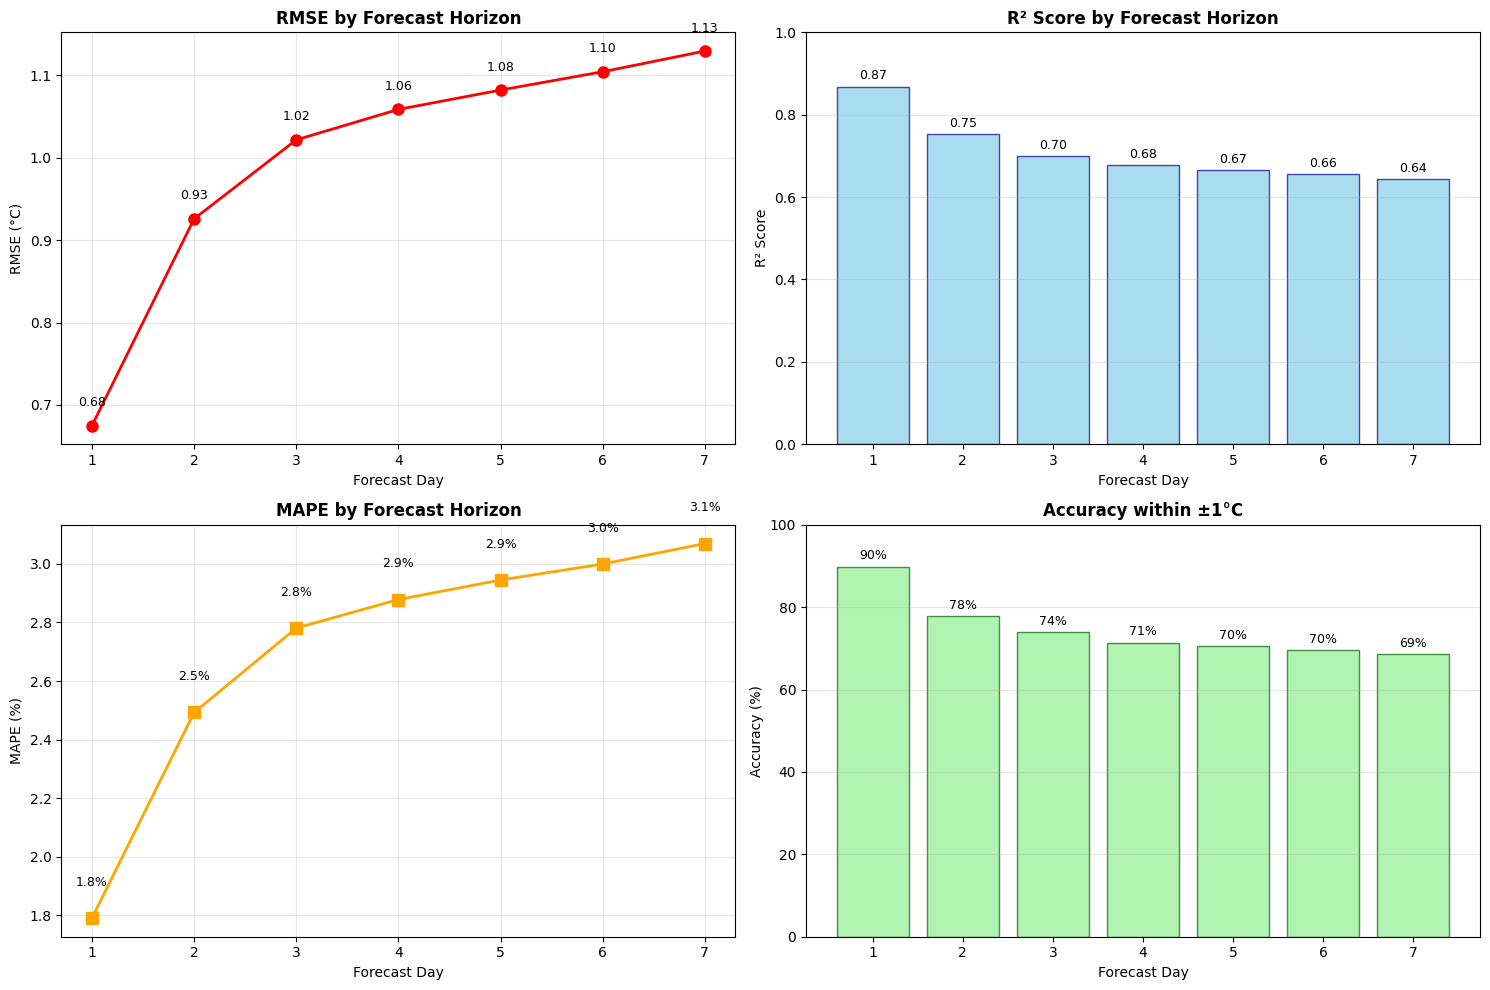

In [59]:
# Visual Performance Analysis
import matplotlib.pyplot as plt

# Create comprehensive performance visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. RMSE by forecast horizon
days = list(range(1, H+1))
rmse_by_day = [sqrt(mean_squared_error(Y_test.iloc[:, h], Y_pred[:, h])) for h in range(H)]

axes[0, 0].plot(days, rmse_by_day, marker='o', linewidth=2, markersize=8, color='red')
axes[0, 0].set_title('RMSE by Forecast Horizon', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Forecast Day')
axes[0, 0].set_ylabel('RMSE (°C)')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(days)

# 2. R² Score by forecast horizon
axes[0, 1].bar(days, r2_scores, color='skyblue', alpha=0.7, edgecolor='navy')
axes[0, 1].set_title('R² Score by Forecast Horizon', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Forecast Day')
axes[0, 1].set_ylabel('R² Score')
axes[0, 1].grid(True, alpha=0.3, axis='y')
axes[0, 1].set_xticks(days)
axes[0, 1].set_ylim(0, 1)

# 3. MAPE by forecast horizon
axes[1, 0].plot(days, mape_scores, marker='s', linewidth=2, markersize=8, color='orange')
axes[1, 0].set_title('MAPE by Forecast Horizon', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Forecast Day')
axes[1, 0].set_ylabel('MAPE (%)')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xticks(days)

# 4. Accuracy within 1°C tolerance
accuracy_1c = []
for h in range(H):
    actual = Y_test.iloc[:, h]
    predicted = Y_pred[:, h]
    within_tolerance = np.abs(actual - predicted) <= 1.0
    accuracy = (within_tolerance.sum() / len(actual)) * 100
    accuracy_1c.append(accuracy)

axes[1, 1].bar(days, accuracy_1c, color='lightgreen', alpha=0.7, edgecolor='darkgreen')
axes[1, 1].set_title('Accuracy within ±1°C', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Forecast Day')
axes[1, 1].set_ylabel('Accuracy (%)')
axes[1, 1].grid(True, alpha=0.3, axis='y')
axes[1, 1].set_xticks(days)
axes[1, 1].set_ylim(0, 100)

# Add performance values as text on bars/points
for i, (day, rmse) in enumerate(zip(days, rmse_by_day)):
    axes[0, 0].text(day, rmse + 0.02, f'{rmse:.2f}', ha='center', va='bottom', fontsize=9)

for i, (day, r2) in enumerate(zip(days, r2_scores)):
    axes[0, 1].text(day, r2 + 0.01, f'{r2:.2f}', ha='center', va='bottom', fontsize=9)

for i, (day, mape) in enumerate(zip(days, mape_scores)):
    axes[1, 0].text(day, mape + 0.1, f'{mape:.1f}%', ha='center', va='bottom', fontsize=9)

for i, (day, acc) in enumerate(zip(days, accuracy_1c)):
    axes[1, 1].text(day, acc + 1, f'{acc:.0f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

### Predict 7 days

In [60]:
X_last = df[selected_features].iloc[[-1]] # shape = (1, n_features)
t2m_next7 = model_xgb.predict(X_last)[0]

# Get the last date in dataset and generate next 7 days
last_date = pd.to_datetime(df["date"].iloc[-1])
print(f"Last data date: {last_date.strftime('%Y-%m-%d (%A)')}")
print(f"Starting forecast from: {(last_date + pd.Timedelta(days=1)).strftime('%Y-%m-%d (%A)')}")
print()

# Generate forecast with dates
forecast_dates = [last_date + pd.Timedelta(days=i) for i in range(1, 8)]

for i, (date, temp) in enumerate(zip(forecast_dates, t2m_next7), start=1):
    day_name = date.strftime('%A')
    date_str = date.strftime('%Y-%m-%d')
    print(f"Day +{i}: {date_str} ({day_name}) → {temp:.2f}°C")

print(f"\nForecast Range: {t2m_next7.min():.2f}°C to {t2m_next7.max():.2f}°C")
print(f"Average Temperature: {t2m_next7.mean():.2f}°C")

# Temperature trend analysis
temp_trend = "increasing" if t2m_next7[-1] > t2m_next7[0] else "decreasing"
temp_change = abs(t2m_next7[-1] - t2m_next7[0])
print(f"7-day Trend: {temp_trend} ({temp_change:.2f}°C change)")

Last data date: 2025-11-14 (Friday)
Starting forecast from: 2025-11-15 (Saturday)

Day +1: 2025-11-15 (Saturday) → 25.48°C
Day +2: 2025-11-16 (Sunday) → 25.49°C
Day +3: 2025-11-17 (Monday) → 25.52°C
Day +4: 2025-11-18 (Tuesday) → 25.42°C
Day +5: 2025-11-19 (Wednesday) → 25.20°C
Day +6: 2025-11-20 (Thursday) → 25.31°C
Day +7: 2025-11-21 (Friday) → 25.26°C

Forecast Range: 25.20°C to 25.52°C
Average Temperature: 25.38°C
7-day Trend: decreasing (0.22°C change)


In [61]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

H = 7

rmse_list = []
mae_list = []
mape_list = []
r2_list = []

for h in range(H):
    y_true_h = Y_test.iloc[:, h]
    y_pred_h = Y_pred[:, h]

    rmse_list.append(np.sqrt(mean_squared_error(y_true_h, y_pred_h)))
    mae_list.append(mean_absolute_error(y_true_h, y_pred_h))
    mape_list.append(mape(y_true_h, y_pred_h))
    r2_list.append(r2_score(y_true_h, y_pred_h))

# ---- Horizontal Display ----
print("==== RMSE ====")
print(" | ".join([f"Day +{i+1}: {rmse_list[i]:.3f}" for i in range(H)]))

print("\n==== MAE ====")
print(" | ".join([f"Day +{i+1}: {mae_list[i]:.3f}" for i in range(H)]))

print("\n==== MAPE (%) ====")
print(" | ".join([f"Day +{i+1}: {mape_list[i]:.2f}%" for i in range(H)]))

print("\n==== R² ====")
print(" | ".join([f"Day +{i+1}: {r2_list[i]:.3f}" for i in range(H)]))

# ---- Accuracy (%) from R² ----
print("\n==== Accuracy (%) from R² ====")
print(" | ".join([f"Day +{i+1}: {r2_list[i]*100:.1f}%" for i in range(H)]))

# ---- Overall metrics ----
rmse_overall = np.sqrt(mean_squared_error(Y_test, Y_pred))
mae_overall = mean_absolute_error(Y_test, Y_pred)
mape_overall = mape(Y_test, Y_pred)
r2_overall = r2_score(Y_test, Y_pred)

print("\n==== Overall ====")
print(f"RMSE={rmse_overall:.3f} | MAE={mae_overall:.3f} | "
      f"MAPE={mape_overall:.2f}% | R²={r2_overall:.3f} | "
      f"Accuracy={(r2_overall*100):.1f}%")

==== RMSE ====
Day +1: 0.675 | Day +2: 0.926 | Day +3: 1.022 | Day +4: 1.059 | Day +5: 1.082 | Day +6: 1.104 | Day +7: 1.130

==== MAE ====
Day +1: 0.501 | Day +2: 0.693 | Day +3: 0.772 | Day +4: 0.800 | Day +5: 0.820 | Day +6: 0.833 | Day +7: 0.852

==== MAPE (%) ====
Day +1: 1.79% | Day +2: 2.49% | Day +3: 2.78% | Day +4: 2.88% | Day +5: 2.94% | Day +6: 3.00% | Day +7: 3.07%

==== R² ====
Day +1: 0.868 | Day +2: 0.753 | Day +3: 0.699 | Day +4: 0.678 | Day +5: 0.666 | Day +6: 0.656 | Day +7: 0.643

==== Accuracy (%) from R² ====
Day +1: 86.8% | Day +2: 75.3% | Day +3: 69.9% | Day +4: 67.8% | Day +5: 66.6% | Day +6: 65.6% | Day +7: 64.3%

==== Overall ====
RMSE=1.010 | MAE=0.753 | MAPE=2.71% | R²=0.709 | Accuracy=70.9%


### Pattern plot

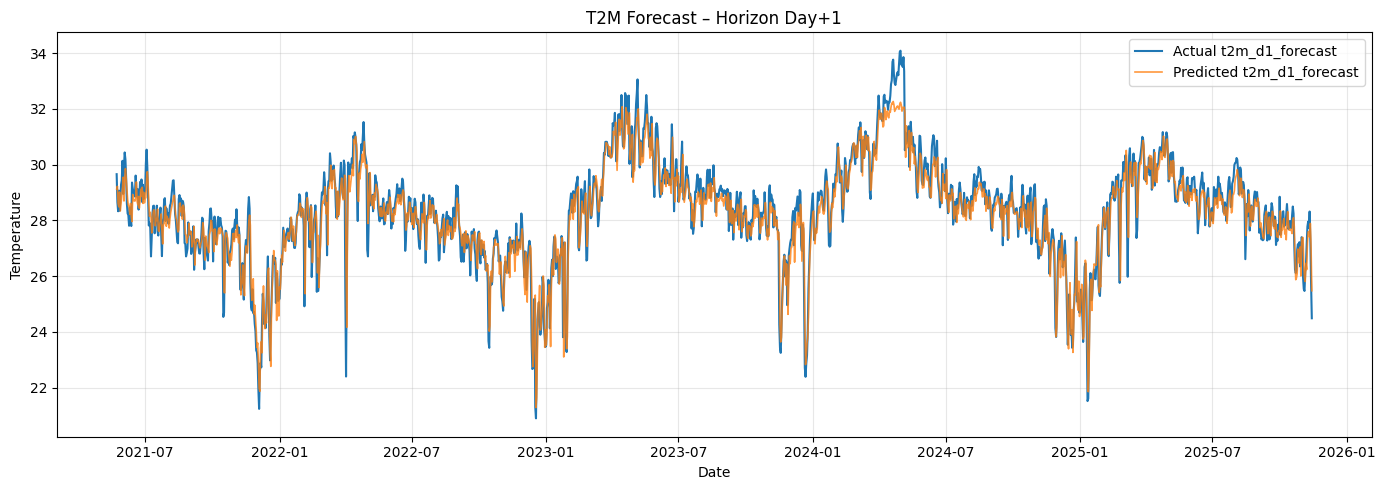

In [62]:
import matplotlib.pyplot as plt

# สร้าง date index สำหรับ test set
dates_test = pd.to_datetime(df["date"].iloc[split_idx:])

# เลือก horizon ที่อยากดู เช่น day+7 = index 6
h = 0   # 0 = day+1, 6 = day+7
target_name = t2m_targets[h]

plt.figure(figsize=(14, 5))
plt.plot(dates_test, Y_test.iloc[:, h], label=f"Actual {target_name}", linewidth=1.5)
plt.plot(dates_test, Y_pred[:, h], label=f"Predicted {target_name}", linewidth=1.2, alpha=0.8)

plt.title(f"T2M Forecast – Horizon Day+{h+1}")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

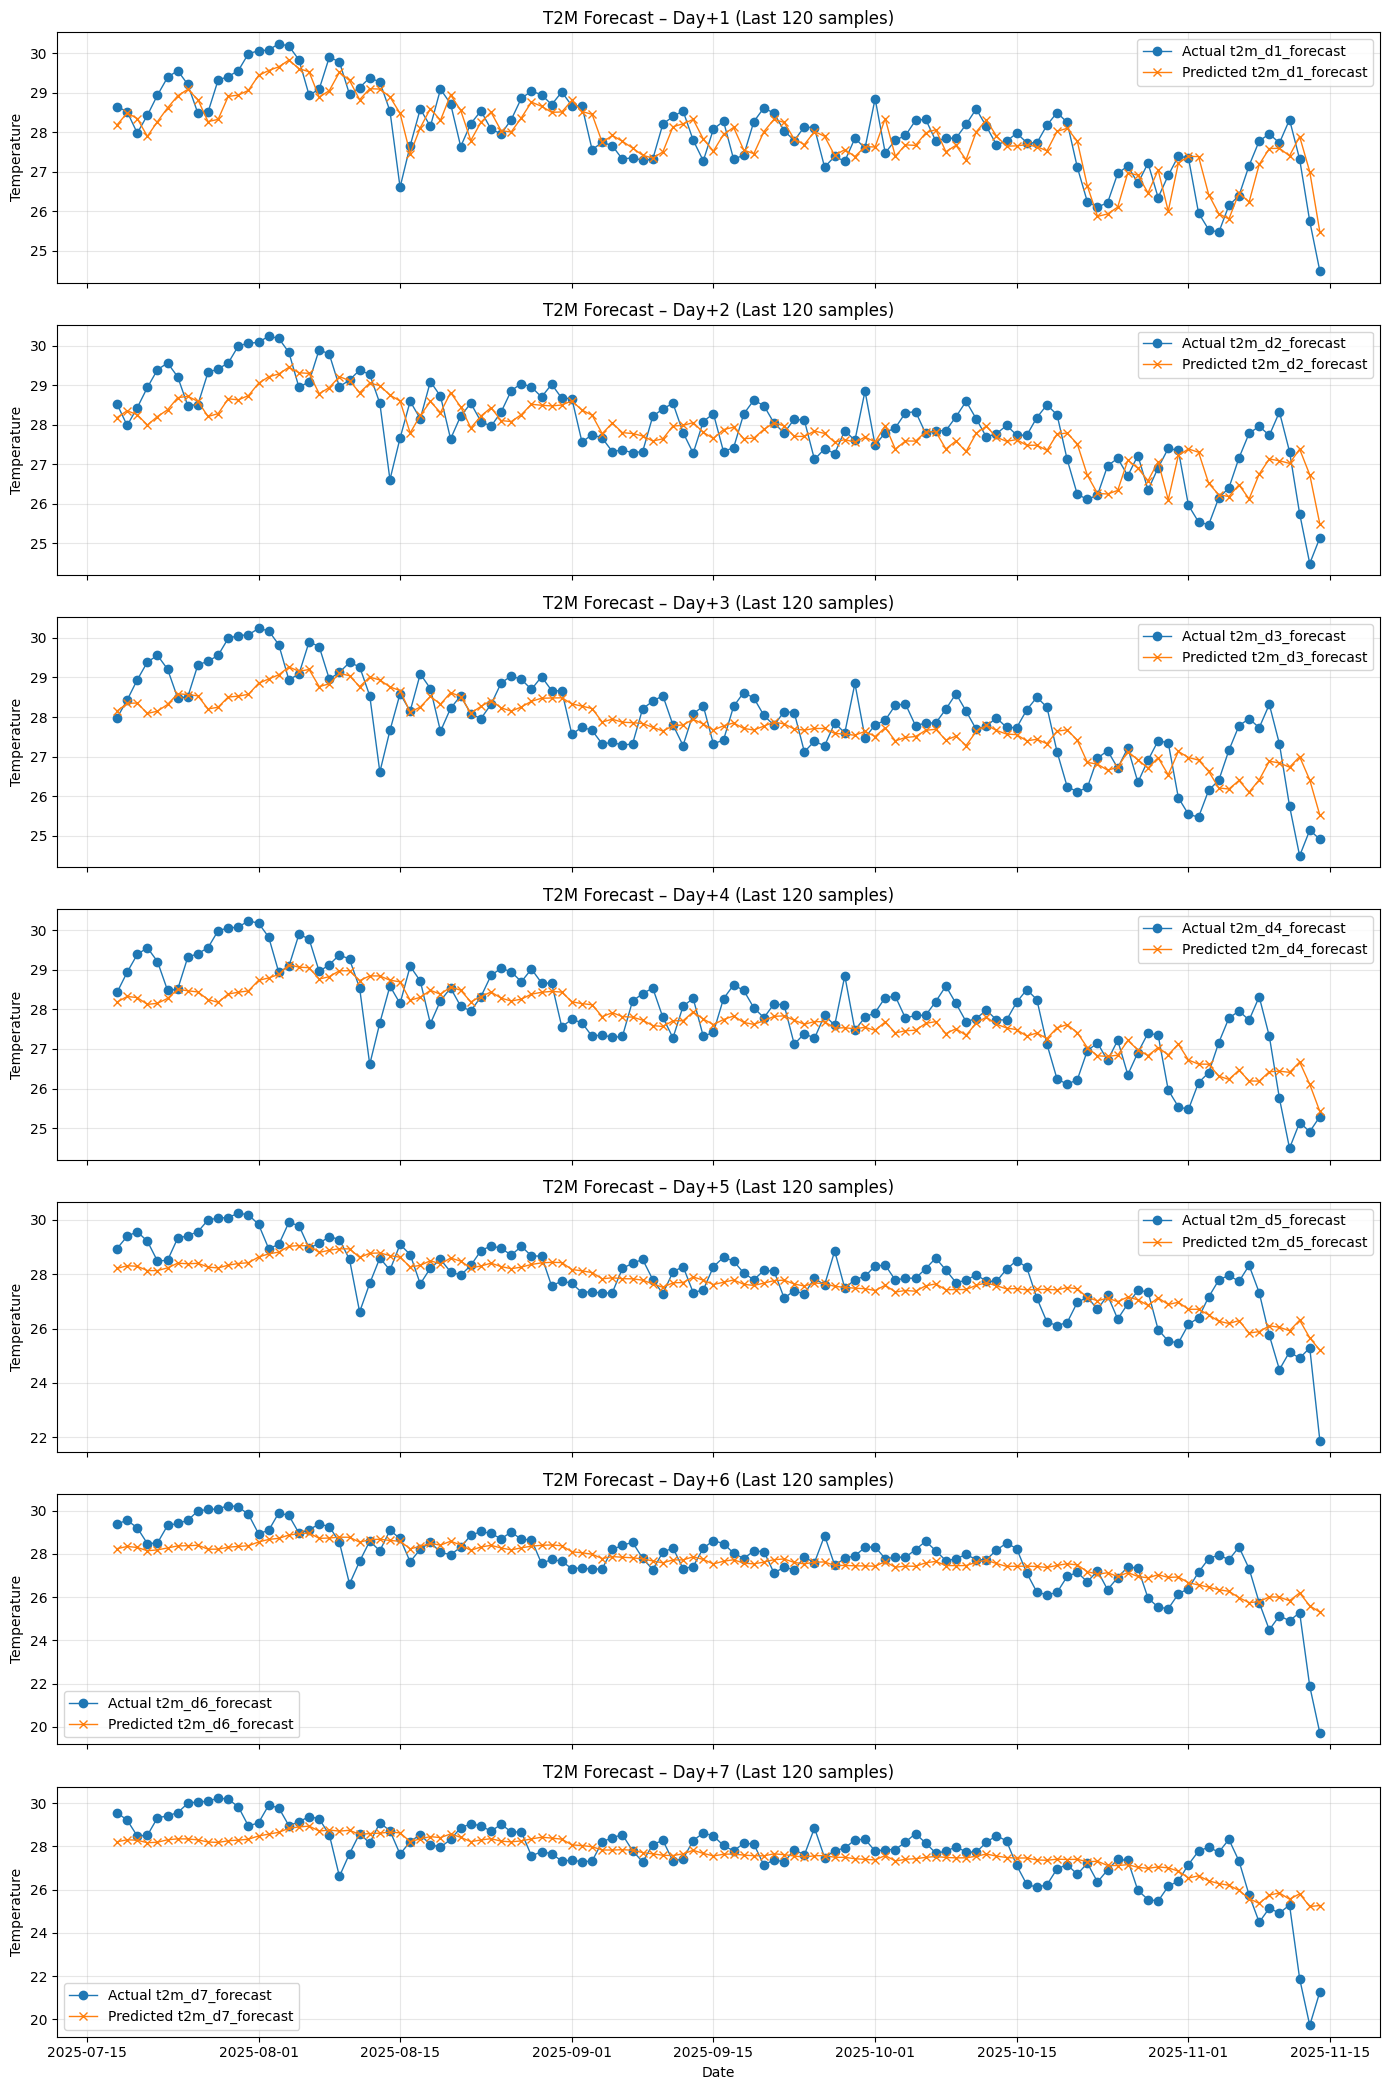

In [63]:
# จำนวนจุดที่อยาก zoom ดู
N = 120  # เช่น 4 เดือนสุดท้าย
days = [f"Day+{i+1}" for i in range(H)]
fig, axs = plt.subplots(H, 1, figsize=(14, 3*H), sharex=True)
for h in range(H):
    dates_zoom = dates_test[-N:]
    y_test_zoom = Y_test.iloc[-N:, h]
    y_pred_zoom = Y_pred[-N:, h]
    axs[h].plot(dates_zoom, y_test_zoom, label=f"Actual {t2m_targets[h]}", marker="o", linewidth=1)
    axs[h].plot(dates_zoom, y_pred_zoom, label=f"Predicted {t2m_targets[h]}", marker="x", linewidth=1)
    axs[h].set_title(f"T2M Forecast – {days[h]} (Last {N} samples)")
    axs[h].set_ylabel("Temperature")
    axs[h].legend()
    axs[h].grid(True, alpha=0.3)
plt.xlabel("Date")
plt.tight_layout()
plt.show()

### Export Weight Model

In [64]:
import joblib

joblib.dump(model_xgb, "../Model/Weight/Xgboost_Multi_T2M_Model.joblib")
print("Model exported to Model/Weight/Xgboost_Multi_T2M_Model.joblib")

Model exported to Model/Weight/Xgboost_Multi_T2M_Model.joblib
